# High-Resolution Image Synthesis with Latent Diffusion Models
# https://arxiv.org/abs/2112.10752

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Training AE (few epochs for demo)...
[AE] epoch 1/3  recon_loss=0.0391
[AE] epoch 2/3  recon_loss=0.0108
[AE] epoch 3/3  recon_loss=0.0158
Training diffusion (few epochs for demo)...
[DDPM] epoch 1/3  eps_loss=0.2563
[DDPM] epoch 2/3  eps_loss=0.1989
[DDPM] epoch 3/3  eps_loss=0.1890
Sampling images...


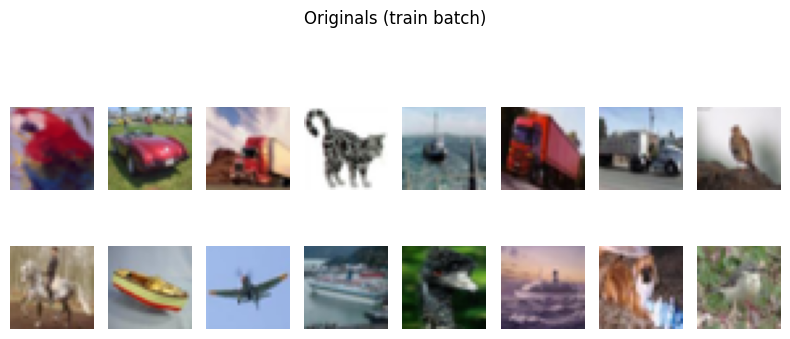

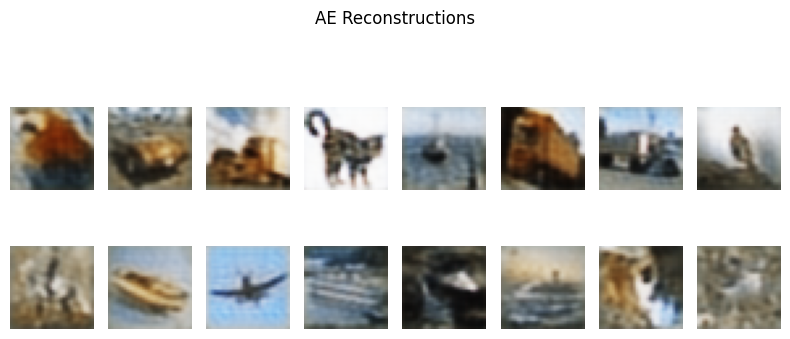

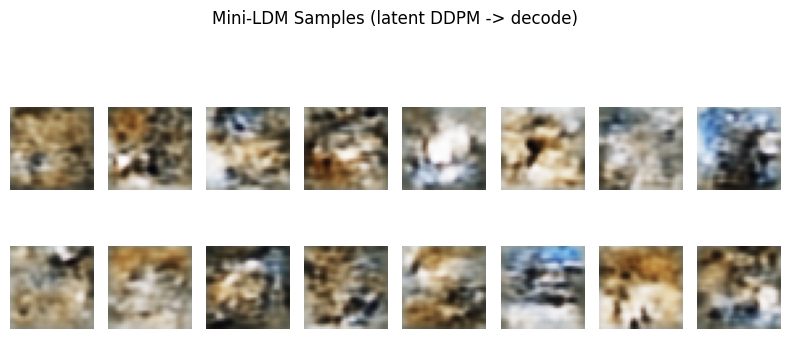

In [1]:
# ----------------------------------------------------------
# Mini-LDM: A Didactic Replication of
# "High-Resolution Image Synthesis with Latent Diffusion Models"
# (Rombach et al., 2022) – classroom-sized, CIFAR-10
# ----------------------------------------------------------
# Pipeline: CIFAR-10 -> Train AE (latent z) -> Train Diffusion UNet on z
#           -> Sample latents -> Decode with AE -> Visualize
# ----------------------------------------------------------

import math, torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 1) Data (CIFAR-10, normalized to [-1,1]) =========
tfm = T.Compose([T.ToTensor(), T.Normalize((0.5,)*3, (0.5,)*3)])
train_set = torchvision.datasets.CIFAR10("./data", train=True,  download=True, transform=tfm)
test_set  = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
classes = train_set.classes

# ========= 2) Autoencoder (mild compression: factor f=4) =========
# Encoder: 32x32x3 -> 8x8xZ ; Decoder reverses it. (Simple L2 loss for pedagogy.)
Z = 8  # latent channels
class Encoder(nn.Module):
    def __init__(self, z=Z):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.GELU(),
            nn.Conv2d(64, 64, 4, 2, 1), nn.GELU(),        # 16x16
            nn.Conv2d(64, 128, 3, 1, 1), nn.GELU(),
            nn.Conv2d(128, 128, 4, 2, 1), nn.GELU(),      # 8x8
            nn.Conv2d(128, z, 3, 1, 1)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z=Z):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(z, 128, 3, 1, 1), nn.GELU(),
            nn.ConvTranspose2d(128, 128, 4, 2, 1), nn.GELU(), # 16x16
            nn.Conv2d(128, 64, 3, 1, 1), nn.GELU(),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.GELU(),   # 32x32
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()              # back to [-1,1]
        )
    def forward(self, z): return self.net(z)

E, D = Encoder().to(Device), Decoder().to(Device)

def train_autoencoder(epochs=3, lr=1e-3):
    opt = optim.AdamW(list(E.parameters()) + list(D.parameters()), lr=lr)
    mse = nn.MSELoss()
    hist=[]
    for ep in range(epochs):
        E.train(); D.train(); run=0.0
        for x,_ in train_loader:
            x = x.to(Device, non_blocking=True)
            z = E(x)
            xhat = D(z)
            loss = mse(xhat, x)
            opt.zero_grad(); loss.backward(); opt.step()
            run += loss.item()
        L = run/len(train_loader); hist.append(L)
        print(f"[AE] epoch {ep+1}/{epochs}  recon_loss={L:.4f}")
    return hist

print("Training AE (few epochs for demo)...")
_ = train_autoencoder(epochs=3)

# ========= 3) Diffusion in latent space (DDPM, tiny UNet) =========
# x0 := z (AE latent). Train eps-theta to predict noise in q(z_t | z_0, t).

# Schedule
T_steps = 200
betas = torch.linspace(1e-4, 0.02, T_steps, device=Device)
alphas = 1.0 - betas
ab = torch.cumprod(alphas, dim=0)                     # alpha_bar_t
sqrt_ab     = torch.sqrt(ab)
sqrt_one_m  = torch.sqrt(1 - ab)

# Time embedding
def sinusoidal_time_embed(t, dim):
    half = dim//2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=Device)/half)
    args = t[:,None].float() * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=1)

# Tiny UNet on Z-channels (8x8 latents)
class ResBlock(nn.Module):
    def __init__(self, ch, tdim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, ch); self.act = nn.SiLU(); self.conv1 = nn.Conv2d(ch, ch, 3, 1, 1)
        self.fc_t  = nn.Linear(tdim, ch)
        self.norm2 = nn.GroupNorm(8, ch); self.conv2 = nn.Conv2d(ch, ch, 3, 1, 1)
    def forward(self, x, t):
        h = self.conv1(self.act(self.norm1(x)))
        h = h + self.fc_t(t)[:, :, None, None]
        h = self.conv2(self.act(self.norm2(h)))
        return x + h

class TinyUNet(nn.Module):
    def __init__(self, zc=Z, base=128, tdim=128):
        super().__init__()
        self.tproj = nn.Sequential(nn.Linear(tdim, tdim), nn.SiLU(), nn.Linear(tdim, tdim))
        self.inp   = nn.Conv2d(zc, base, 3, 1, 1)
        self.d1    = ResBlock(base, tdim)
        self.down  = nn.Conv2d(base, base, 4, 2, 1)     # 8x8 -> 4x4
        self.mid1  = ResBlock(base, tdim)
        self.up    = nn.ConvTranspose2d(base, base, 4, 2, 1) # 4x4 -> 8x8
        self.u1    = ResBlock(base, tdim)
        self.out   = nn.Conv2d(base, zc, 3, 1, 1)
    def forward(self, x, t_emb):
        t = self.tproj(t_emb)
        h = self.inp(x)
        h = self.d1(h, t)
        d = self.down(h)
        d = self.mid1(d, t)
        u = self.up(d)
        h = self.u1(h + u, t)   # skip
        return self.out(h)

eps_model = TinyUNet().to(Device)
optim_eps = optim.AdamW(eps_model.parameters(), lr=1e-3)

def q_sample(z0, t, noise=None):
    if noise is None: noise = torch.randn_like(z0)
    a = sqrt_ab[t][:, None, None, None]
    b = sqrt_one_m[t][:, None, None, None]
    return a * z0 + b * noise

def train_diffusion(epochs=3):
    eps_model.train()
    for ep in range(epochs):
        run=0.0; n=0
        for x,_ in train_loader:
            x = x.to(Device, non_blocking=True)
            with torch.no_grad():
                z0 = E(x).detach()
            t = torch.randint(0, T_steps, (x.size(0),), device=Device)
            noise = torch.randn_like(z0)
            zt = q_sample(z0, t, noise)
            t_emb = sinusoidal_time_embed(t, 128)
            pred = eps_model(zt, t_emb)
            loss = nn.functional.mse_loss(pred, noise)
            optim_eps.zero_grad(set_to_none=True); loss.backward(); optim_eps.step()
            run += loss.item(); n += 1
        print(f"[DDPM] epoch {ep+1}/{epochs}  eps_loss={run/n:.4f}")

print("Training diffusion (few epochs for demo)...")
train_diffusion(epochs=3)

# ========= 4) Sampling in latent space, then decode =========
@torch.no_grad()
def p_sample_loop(n_samples=16):
    eps_model.eval(); E.eval(); D.eval()
    z = torch.randn(n_samples, Z, 8, 8, device=Device)
    for t in reversed(range(T_steps)):
        tb = torch.full((n_samples,), t, device=Device, dtype=torch.long)
        t_emb = sinusoidal_time_embed(tb, 128)
        eps = eps_model(z, t_emb)
        beta = betas[t]; alpha = alphas[t]; abar = ab[t]
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = (1 - alpha) / torch.sqrt(1 - abar)
        z = coef1 * (z - coef2 * eps)
        if t > 0:
            z = z + torch.sqrt(beta) * torch.randn_like(z)
    x = D(z).clamp(-1,1)
    return x

print("Sampling images...")
samples = p_sample_loop(16).cpu()

# ========= 5) Visualize: AE reconstructions + Generated samples =========
@torch.no_grad()
def show_grid(tensor_bchw, title):
    imgs = (tensor_bchw * 0.5 + 0.5).numpy()  # [-1,1] -> [0,1]
    plt.figure(figsize=(8,4)); plt.suptitle(title)
    for i in range(min(16, imgs.shape[0])):
        plt.subplot(2,8,i+1); plt.imshow(np.transpose(imgs[i], (1,2,0))); plt.axis('off')
    plt.tight_layout(); plt.show()

# Recon grid for a quick sanity check
xb, _ = next(iter(train_loader))
xb = xb[:16].to(Device)
with torch.no_grad():
    recon = D(E(xb)).cpu()
show_grid(xb.cpu(), "Originals (train batch)")
show_grid(recon,    "AE Reconstructions")
show_grid(samples,  "Mini-LDM Samples (latent DDPM -> decode)")


In [5]:
# Summaries for the Mini-LDM (Latent Diffusion) components
# (assumes Encoder, Decoder, TinyUNet, and Z are already defined)

!pip install -q torchinfo
from torchinfo import summary
import torch

# Fallback for Z if not defined
try:
    Z
except NameError:
    Z = 8

enc = Encoder(z=Z)
dec = Decoder(z=Z)
unet = TinyUNet(zc=Z, base=128, tdim=128)

print("\n=== Mini-LDM: Encoder ===")
summary(
    model=enc,
    input_size=(1, 3, 32, 32),
    col_names=("input_size", "output_size", "num_params", "trainable"),
    col_width=20,
    row_settings=("var_names",),
)

print("\n=== Mini-LDM: Decoder ===")
summary(
    model=dec,
    input_size=(1, Z, 8, 8),
    col_names=("input_size", "output_size", "num_params", "trainable"),
    col_width=20,
    row_settings=("var_names",),
)

print("\n=== Mini-LDM: Denoiser UNet ===")
# TinyUNet expects (latent, time_embedding)
x_latent = torch.zeros(1, Z, 8, 8)
t_emb    = torch.zeros(1, 128)
summary(
    model=unet,
    input_data=(x_latent, t_emb),
    col_names=("input_size", "output_size", "num_params", "trainable"),
    col_width=20,
    row_settings=("var_names",),
)



=== Mini-LDM: Encoder ===

=== Mini-LDM: Decoder ===

=== Mini-LDM: Denoiser UNet ===


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyUNet (TinyUNet)                      [1, 8, 8, 8]         [1, 8, 8, 8]         --                   True
├─Sequential (tproj)                     [1, 128]             [1, 128]             --                   True
│    └─Linear (0)                        [1, 128]             [1, 128]             16,512               True
│    └─SiLU (1)                          [1, 128]             [1, 128]             --                   --
│    └─Linear (2)                        [1, 128]             [1, 128]             16,512               True
├─Conv2d (inp)                           [1, 8, 8, 8]         [1, 128, 8, 8]       9,344                True
├─ResBlock (d1)                          [1, 128, 8, 8]       [1, 128, 8, 8]       --                   True
│    └─GroupNorm (norm1)                 [1, 128, 8, 8]       [1, 128, 8, 8]       256                  True
│    └─SiLU (act